# First implementation of Machine Learning Algorithm

In this file, we are going to import data from a file .csv that we take from chornograf.
We have to parse him and put into an array.
Finally we will insert some machin Learning algorithm with the librairy sklearn.

To do this, we will use some librairy as pandas, matplotlib, numpy, sklearn and some others.


In [1]:
from sklearn import linear_model
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


Read the file DataDemeter.csv

SELECT mean("temperature") AS "mean_temperature", mean("moisture-percent") AS "mean_moisture-percent"

FROM "demeter"."autogen"."chirp-left"

WHERE time > now() -2536h

GROUP BY time(30m) FILL(null)

# Import of data 

Reading of the file in dataframe.

Creation of the dataframe with the variation of the moisture and temperature.

The file traitement contain all the method to transform our dataframe.

In [2]:
from traitement import Traitement

df = pd.read_csv('DataDemeter.csv')
t= Traitement()
#Add the information about the variation of the moisture and the temperature
df = t.ajoutData(df)

## Add the information of watering

The watering is done at 11.00 AM or 12.00 AM 

In [3]:
import datetime

df = t.arrosageHist(df,1)
df['index'] = df.index
nligne = df.shape[0]
position = df.shape[1]-1
dfdebut = df.copy()
# Eliminate value that are incomplet
for i in range(nligne):
    df.iloc[i,position] = (i-6)//48 + 1
df.drop(df.index[df['index'] == 76], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 75], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 15], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 102], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 96], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 97], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 98], axis = 0, inplace = True)
df.drop(df.index[df['index'] == 41], axis = 0, inplace = True)

# Delete NaN Value

In [4]:
i = 6

df = t.eliminateNaNValue(df,i)
#Delete the data that are not inside a loop of one day
df.drop(df.index[range(0,i+48*3)],axis = 0,inplace = True)

nligne = df.shape[0]
print("nombre de ligne", nligne)
DF = df.copy()

nombre de ligne 4395


In [6]:
# Verify that there is no NaN value
nligne = df.shape[0]
nColumn = df.shape[1]
print(df.isnull().sum())
for i in range(nligne):
    if df.iloc[i,:].isnull().values.any():
        print(df.index[i])
        

date                     0
mean_moisture-percent    0
mean_temperature         0
moistureAdd              0
temperatureAdd           0
Arrosage                 0
TAfterArrosage           0
ArrosageHist             0
index                    0
dtype: int64


# Data Test

Randomly extraction of data for testing. 14 days are used for the test.

Each data that are use for testing are exclude for training

In [7]:
import random
jour = nligne //48
print("nb de jour totale : ",jour)
incr = 0
jourTest = random.sample(range(1,jour),k=14)
jourTest.sort()
print("jour de test : ",jourTest)


nb de jour totale :  91
jour de test :  [9, 10, 11, 21, 22, 38, 42, 43, 46, 49, 56, 70, 76, 79]


In [8]:
indTest = []
for el in jourTest:
    indTest = np.append(indTest,range(int(48*(el-1)),int(48*el)))
indTest = indTest.astype(int)
dataTest = df.iloc[indTest,:].copy()
DF = df.copy()
df.drop(df.index[indTest],axis = 0,inplace = True)


# Analyse the dataFrame


## Least Square Multiple Linear Regression

We use the parameter of the moisture, the temperature, the watering and the time since the last watering

In [20]:
reg2 = linear_model.LinearRegression()
reg2.fit(df[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']],df.moistureAdd)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
reg2.coef_

array([-0.02061095,  0.00357117,  0.23326872,  0.00028366])

In [22]:
reg2.intercept_

0.009963810374464711

In [23]:
reg2.predict([[31,25,10,0]])[0]

1.7929906932877624



# Test our dataTest

We are going to use different algorithm. 

LSMLR, Regression Elasticnet and Gradient Boosting Regression


In [25]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor


ErrTempsAbsLin = np.zeros(20)
ErrTempsAbsElas = np.zeros(20)
ErrTempsAbsBoost = np.zeros(20)

# We do our testing on 20 differents separation of the data
for k in range(20):
    # Separation of the data
    df = DF.copy()
    jour = nligne //48
    incr = 0
    jourTest = random.sample(range(1,jour),k=14)
    jourTest.sort()
    indTest = []
    for el in jourTest:
        indTest = np.append(indTest,range(int(48*(el-1)),int(48*el)))
    indTest = indTest.astype(int)
    dataTest = df.iloc[indTest,:].copy()
    df.drop(df.index[indTest],axis = 0,inplace = True)
    
    
    # Learning with LSMLR
    reg2 = linear_model.LinearRegression()
    reg2.fit(df[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']],df.moistureAdd)
    init = 0+48*0
    dataTest['resultLin'] = dataTest.index
    positionLin = dataTest.shape[1]-1
    
    # Learning with Elasticnet
    regElas = ElasticNet(random_state=0)
    regElas.fit(df[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']],df.moistureAdd)
    dataTest['resultElasticNet'] = dataTest.index
    positionElas = dataTest.shape[1]-1
    
    #Learning with Gradient Boosting
    regBoost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
     max_depth=1, random_state=0, loss='ls').fit(df[['mean_moisture-percent','mean_temperature','Arrosage','TAfterArrosage']],df.moistureAdd)
    dataTest['Regression Boost'] = dataTest.index
    positionBoost = dataTest.shape[1]-1

    
    # Then we do some prediction and compare the result with true value
    StartHumidity = dataTest.iloc[init,1]

    TestSize = dataTest.shape[0]
    result2 = np.zeros(TestSize)
    resultElas = np.zeros(TestSize)
    resultBoost = np.zeros(TestSize)
    
    result2[0] = StartHumidity
    resultElas[0] = StartHumidity
    resultBoost[0] = StartHumidity
    dataTest.iloc[int(0),positionLin] = result2[0]
    dataTest.iloc[int(0),positionElas] = resultElas[0]
    dataTest.iloc[int(0),positionBoost] = resultBoost[0]
    for i in range(0,TestSize-1):
        if i%48 == 0:
            StartHumidity = dataTest.iloc[init+i,1]
            result2[i+1] = StartHumidity + reg2.predict([[StartHumidity,dataTest.iloc[init+i,2],dataTest.iloc[init+i,5],dataTest.iloc[init+i,6]]])[0]
            resultElas[i+1] = StartHumidity + regElas.predict([[StartHumidity,dataTest.iloc[init+i,2],dataTest.iloc[init+i,5],dataTest.iloc[init+i,6]]])[0]
            resultBoost[i+1] = StartHumidity + regBoost.predict([[StartHumidity,dataTest.iloc[init+i,2],dataTest.iloc[init+i,5],dataTest.iloc[init+i,6]]])[0]
        else: 
            result2[i+1] = result2[i] + reg2.predict([[result2[i],dataTest.iloc[init+i,2],dataTest.iloc[init+i,5],dataTest.iloc[init+i,6]]])[0]
            resultElas[i+1] = resultElas[i] + regElas.predict([[resultElas[i],dataTest.iloc[init+i,2],dataTest.iloc[init+i,5],dataTest.iloc[init+i,6]]])[0]
            resultBoost[i+1] = resultBoost[i] + regBoost.predict([[resultBoost[i],dataTest.iloc[init+i,2],dataTest.iloc[init+i,5],dataTest.iloc[init+i,6]]])[0]

        dataTest.iloc[int(i+init+1),positionLin] = result2[i+1]
        dataTest.iloc[int(i+init+1),positionElas] = resultElas[i+1]
        dataTest.iloc[int(i+init+1),positionBoost] = resultBoost[i+1]
    ErrTempsAbsLin[k] = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,positionLin].values))
    ErrTempsAbsElas[k] = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,positionElas].values))
    ErrTempsAbsBoost[k] = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,positionBoost].values))

print("\n Moyenne d'erreur : ", np.mean(ErrTempsAbsLin))
print("\n Moyenne d'erreur : ", np.mean(ErrTempsAbsElas))

print("\n Moyenne d'erreur : ", np.mean(ErrTempsAbsBoost))




 Moyenne d'erreur :  1.88951114784

 Moyenne d'erreur :  2.00940599918

 Moyenne d'erreur :  0.805641692063


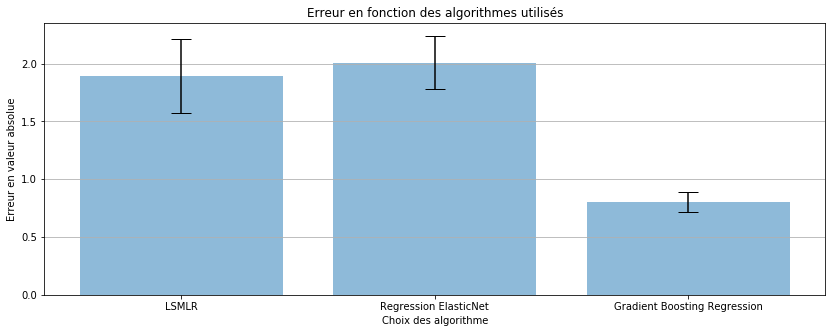

In [26]:
# Graphique of the difference in function of the algorithm used

error = [np.std(ErrTempsAbsLin),np.std(ErrTempsAbsElas),np.std(ErrTempsAbsBoost)]

left = [1, 2,3] 
  
# heights of bars 
height = [np.mean(ErrTempsAbsLin),np.mean(ErrTempsAbsElas),np.mean(ErrTempsAbsBoost)]
  
# labels for bars 
tick_label = ['LSMLR', 'Regression ElasticNet','Gradient Boosting Regression'] 

fig, ax = plt.subplots(figsize=(14,5)) # set the size that you'd like (width, height)
# plotting a bar chart 
ax.bar(left, height,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
#plt.bar(left, height, tick_label = tick_label, 
#        width = 0.8, color = ['red', 'blue']) 


ax.set_xticks(left)
ax.set_xticklabels(tick_label)
ax.set_title('Erreur en fonction des algorithmes utilisés')
ax.yaxis.grid(True)
# naming the x-axis 
plt.xlabel('Choix des algorithme') 
# naming the y-axis 
plt.ylabel('Erreur en valeur absolue') 
# plot title 
  
# function to show the plot 
plt.show() 

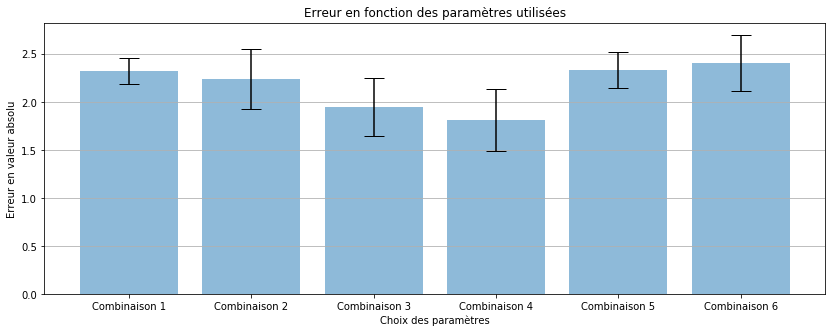

In [28]:
# x-coordinates of left sides of bars  

error = [np.std(ErrTempsAbs1), np.std(ErrTempsAbs2),np.std(ErrTempsAbs3),np.std(ErrTempsAbs4),np.std(ErrTempsAbs5),np.std(ErrTempsAbs6)]

left = [1, 2,3,4,5,6] 
  
# heights of bars 
height = [np.mean(ErrTempsAbs1),np.mean(ErrTempsAbs2),np.mean(ErrTempsAbs3),np.mean(ErrTempsAbs4),np.mean(ErrTempsAbs5),np.mean(ErrTempsAbs6)]
  
# labels for bars 
tick_label = ['Combinaison 1', 'Combinaison 2', 'Combinaison 3','Combinaison 4','Combinaison 5','Combinaison 6'] 

fig, ax = plt.subplots(figsize=(14,5)) # set the size that you'd like (width, height)
# plotting a bar chart 
ax.bar(left, height,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
#plt.bar(left, height, tick_label = tick_label, 
#        width = 0.8, color = ['red', 'blue']) 


ax.set_xticks(left)
ax.set_xticklabels(tick_label)
ax.set_title('Erreur en fonction des paramètres utilisées')
ax.yaxis.grid(True)
# naming the x-axis 
plt.xlabel('Choix des paramètres') 
# naming the y-axis 
plt.ylabel('Erreur en valeur absolu') 
# plot title 
  
# function to show the plot 
plt.show() 

# Separation of the Data frame

Separation in three different part 

One part for the watering. df['TAfterArrosage'] == 0. When we water, the time is equal to 0.

The second part is for the evaporation time

The third part if for stabilization.


In [27]:
limite = 240
dfArrosage = df.loc[df['TAfterArrosage'] == 0]
tmp = df.loc[df['TAfterArrosage'] > 0]
dfStabilisation = df.loc[df['TAfterArrosage'] > limite].copy()
dfEvaporation = tmp.loc[df['TAfterArrosage'] <= limite].copy()

In [28]:
# Pour faire le régression linear sur le moment d'arrosage
regLinearAro = linear_model.LinearRegression()
regLinearAro.fit(dfArrosage[['mean_moisture-percent','Arrosage']],dfArrosage.moistureAdd)
regLinearAro.intercept_
regLinearAro.coef_

array([-0.05350572,  0.01107927])

In [29]:
regLinearEva = linear_model.LinearRegression()
regLinearEva.fit(dfEvaporation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist']],dfEvaporation.moistureAdd)
regLinearEva.intercept_
regLinearEva.coef_

array([-0.01890069, -0.05717605,  0.00875568,  0.00106561])

In [30]:
regLinearSta = linear_model.LinearRegression()
regLinearSta.fit(dfStabilisation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist']],dfStabilisation.moistureAdd)
regLinearSta.intercept_
regLinearSta.coef_

array([ -3.63390622e-03,   6.14875476e-03,   1.72590818e-05,
         7.85564617e-04])

In [31]:
#Pour tester sur la base de données de training
init = 0
base = dataTest 


In [34]:
ErrTempsAbsSepare = np.zeros(20)
limite = 240
for k in range(20):
    
    df = DF.copy()
    jour = nligne //48
    incr = 0
    jourTest = random.sample(range(1,jour),k=14)
    jourTest.sort()
    indTest = []
    for el in jourTest:
        indTest = np.append(indTest,range(int(48*(el-1)),int(48*el)))
    indTest = indTest.astype(int)
    dataTest = df.iloc[indTest,:].copy()
    df.drop(df.index[indTest],axis = 0,inplace = True)
    
    dfarro = df.copy()
    dfArrosage = dfarro.loc[dfarro['TAfterArrosage'] == 0]
    tmp = dfarro.loc[dfarro['TAfterArrosage'] > 0]
    dfStabilisation = dfarro.loc[dfarro['TAfterArrosage'] > limite].copy()
    dfEvaporation = tmp.loc[dfarro['TAfterArrosage'] <= limite].copy()

    regLinearAro = linear_model.LinearRegression()
    regLinearAro.fit(dfArrosage[['mean_moisture-percent','Arrosage']],dfArrosage.moistureAdd)
    regLinearEva = linear_model.LinearRegression()
    regLinearEva.fit(dfEvaporation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist']],dfEvaporation.moistureAdd)
    regLinearSta = linear_model.LinearRegression()
    regLinearSta.fit(dfStabilisation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist']],dfStabilisation.moistureAdd)


    dataTest['LSMLR Séparé'] = dataTest.index
    StartHumidity = dataTest.iloc[0,1]
    position = dataTest.shape[1]-1
    TestSize = dataTest.shape[0]
    result = np.zeros(TestSize)

    for i in range(0,TestSize-1):
        dataTest.iloc[int(i),position] = StartHumidity

        if dataTest.iloc[i,6] == 0:
            StartHumidity = dataTest.iloc[i,1]
            result[i] = StartHumidity + regLinearAro.predict([[StartHumidity,dataTest.iloc[i,5]]])[0]
        elif dataTest.iloc[i,6] <= limite:
            result[i] = StartHumidity + regLinearEva.predict([[StartHumidity,dataTest.iloc[i,2],dataTest.iloc[i,6],dataTest.iloc[i,7]]])[0]
        else:
            result[i] = StartHumidity + regLinearSta.predict([[StartHumidity,dataTest.iloc[i,2],dataTest.iloc[i,6],dataTest.iloc[i,7]]])[0]

        StartHumidity = result[i]
    dataTest.iloc[TestSize-1,position] = StartHumidity


    ErrTempsAbsSepare[k] = np.mean(np.absolute(dataTest.iloc[:,1].values-dataTest.iloc[:,position].values))


print("Moyenne d'erreur absolue : ",np.mean(ErrTempsAbsSepare))


Moyenne d'erreur absolue :  0.9426625293


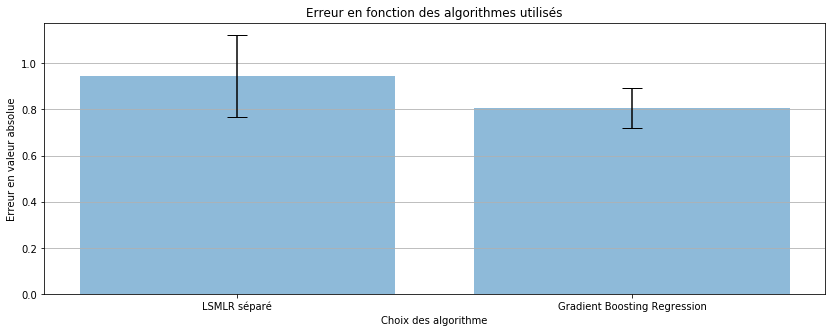

In [35]:
# x-coordinates of left sides of bars  

error = [np.std(ErrTempsAbsSepare),np.std(ErrTempsAbsBoost)]

left = [1, 2] 
  
# heights of bars 
height = [np.mean(ErrTempsAbsSepare),np.mean(ErrTempsAbsBoost)]
  
# labels for bars 
tick_label = ['LSMLR séparé','Gradient Boosting Regression'] 

fig, ax = plt.subplots(figsize=(14,5)) # set the size that you'd like (width, height)
# plotting a bar chart 
ax.bar(left, height,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
#plt.bar(left, height, tick_label = tick_label, 
#        width = 0.8, color = ['red', 'blue']) 


ax.set_xticks(left)
ax.set_xticklabels(tick_label)
ax.set_title('Erreur en fonction des algorithmes utilisés')
ax.yaxis.grid(True)
# naming the x-axis 
plt.xlabel('Choix des algorithme') 
# naming the y-axis 
plt.ylabel('Erreur en valeur absolue') 
# plot title 
  
# function to show the plot 
plt.show() 

# Graphic

Creation des graphics de la courbe d'évolution de la température



Text(0, 0.5, 'Watering quantity')

<Figure size 432x288 with 0 Axes>

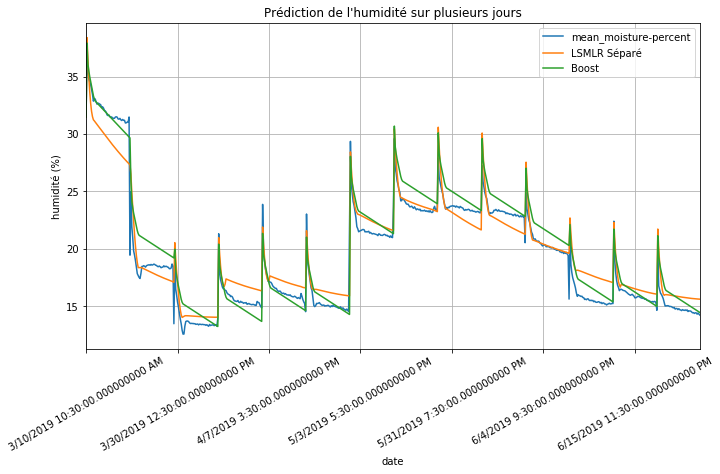

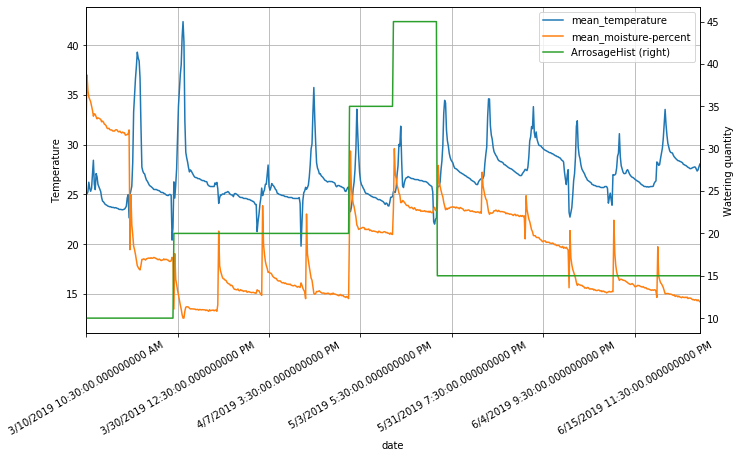

In [21]:
fig = plt.figure()
ax = dataTest.plot(x='date', y=['mean_moisture-percent','LSMLR Séparé','Boost'],figsize=(11, 6),rot=30,grid=True, title="Prédiction de l'humidité sur plusieurs jours")
ax.set_ylabel("humidité (%)")

ax = dataTest.plot(x='date', y=['mean_temperature','mean_moisture-percent','ArrosageHist'],secondary_y=['ArrosageHist'],figsize=(11, 6),rot=30,grid=True)

ax.set_ylabel("Temperature")
ax.right_ax.set_ylabel('Watering quantity')


#dfTest.loc[dfTest['TAfterArrosage'] == 30]

## Research of the best delimitation for the partitionnment in 3 parts

Try to find the best delimitation in fonction of the watering

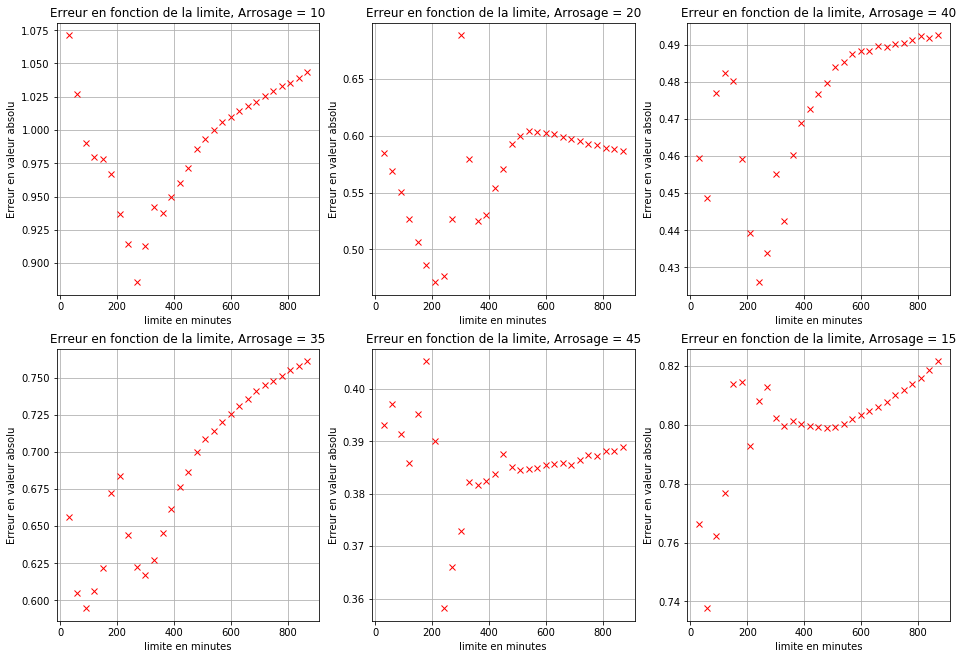

In [37]:
j = 1
f, ax = plt.subplots(figsize=(16,11))
for ARRO in [10,20,40,35,45,15]:
    dfarro = DF.loc[DF['ArrosageHist'] == ARRO]
    dfArrosage = dfarro.loc[dfarro['TAfterArrosage'] == 0]
    tmp = dfarro.loc[dfarro['TAfterArrosage'] > 0]

    bestLimite = 0
    errmin = 1000
    res = np.zeros(900//30-1)
    for limite in range(30,900,30):

        dfStabilisation = dfarro.loc[dfarro['TAfterArrosage'] > limite].copy()
        dfEvaporation = tmp.loc[dfarro['TAfterArrosage'] <= limite].copy()

        regLinearAro = linear_model.LinearRegression()
        regLinearAro.fit(dfArrosage[['mean_moisture-percent','Arrosage','index']],dfArrosage.moistureAdd)
        regLinearEva = linear_model.LinearRegression()
        regLinearEva.fit(dfEvaporation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfEvaporation.moistureAdd)
        regLinearSta = linear_model.LinearRegression()
        regLinearSta.fit(dfStabilisation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfStabilisation.moistureAdd)


        databasetest = dfarro.copy()
        databasetest['resultSepare'] = databasetest.index
        StartHumidity = databasetest.iloc[0,1]
        position = databasetest.shape[1]-1
        TestSize = databasetest.shape[0]
        result = np.zeros(TestSize)

        for i in range(0,TestSize-1):
            databasetest.iloc[int(i),position] = StartHumidity

            if databasetest.iloc[i,6] == 0:
                StartHumidity = databasetest.iloc[i,1]
                result[i] = StartHumidity + regLinearAro.predict([[StartHumidity,databasetest.iloc[i,5],databasetest.iloc[i,8]]])[0]
            elif databasetest.iloc[i,6] <= limite:
                result[i] = StartHumidity + regLinearEva.predict([[StartHumidity,databasetest.iloc[i,2],databasetest.iloc[i,6],databasetest.iloc[i,7],databasetest.iloc[i,8]]])[0]
            else:
                result[i] = StartHumidity + regLinearSta.predict([[StartHumidity,databasetest.iloc[i,2],databasetest.iloc[i,6],databasetest.iloc[i,7],databasetest.iloc[i,8]]])[0]

            StartHumidity = result[i]
        databasetest.iloc[TestSize-1,position] = StartHumidity


        ErrSepare = np.mean(databasetest.iloc[:,1].values-databasetest.iloc[:,position].values)
        ErrSepareAbs = np.mean(np.absolute(databasetest.iloc[:,1].values-databasetest.iloc[:,position].values))
        res[limite//30-1]=ErrSepareAbs
        if (ErrSepareAbs< errmin):
            bestLimite = limite
            errmin = ErrSepareAbs
    
    #print("BEST LIMITE pour un arrosage de ", ARRO ," : ",bestLimite)
    plt.subplot(2,3,j)
    plt.grid(b = True)
    plt.plot(range(30,900,30), res, 'rx')
    plt.xlabel('limite en minutes')
    plt.ylabel('Erreur en valeur absolu')
    plt.title('Erreur en fonction de la limite, Arrosage = '+str(ARRO))
    j = j + 1
plt.show()


# Research the best delimitation for all watering 

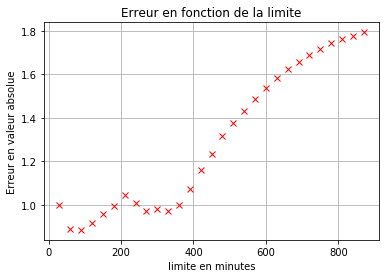

In [38]:
dfarro = df.copy()
dfArrosage = dfarro.loc[dfarro['TAfterArrosage'] == 0]
tmp = dfarro.loc[dfarro['TAfterArrosage'] > 0]

bestLimite = 0
errmin = 1000
res = np.zeros(900//30-1)
for limite in range(30,900,30):

    dfStabilisation = dfarro.loc[dfarro['TAfterArrosage'] > limite].copy()
    dfEvaporation = tmp.loc[dfarro['TAfterArrosage'] <= limite].copy()

    regLinearAro = linear_model.LinearRegression()
    regLinearAro.fit(dfArrosage[['mean_moisture-percent','Arrosage','index']],dfArrosage.moistureAdd)
    regLinearEva = linear_model.LinearRegression()
    regLinearEva.fit(dfEvaporation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfEvaporation.moistureAdd)
    regLinearSta = linear_model.LinearRegression()
    regLinearSta.fit(dfStabilisation[['mean_moisture-percent','mean_temperature','TAfterArrosage','ArrosageHist','index']],dfStabilisation.moistureAdd)


    databasetest = dataTest.copy()
    databasetest['resultSepare'] = databasetest.index
    StartHumidity = databasetest.iloc[0,1]
    position = databasetest.shape[1]-1
    TestSize = databasetest.shape[0]
    result = np.zeros(TestSize)

    for i in range(0,TestSize-1):
        databasetest.iloc[int(i),position] = StartHumidity

        if databasetest.iloc[i,6] == 0:
            StartHumidity = databasetest.iloc[i,1]
            result[i] = StartHumidity + regLinearAro.predict([[StartHumidity,databasetest.iloc[i,5],databasetest.iloc[i,8]]])[0]
        elif databasetest.iloc[i,6] <= limite:
            result[i] = StartHumidity + regLinearEva.predict([[StartHumidity,databasetest.iloc[i,2],databasetest.iloc[i,6],databasetest.iloc[i,7],databasetest.iloc[i,8]]])[0]
        else:
            result[i] = StartHumidity + regLinearSta.predict([[StartHumidity,databasetest.iloc[i,2],databasetest.iloc[i,6],databasetest.iloc[i,7],databasetest.iloc[i,8]]])[0]

        StartHumidity = result[i]
    databasetest.iloc[TestSize-1,position] = StartHumidity


    ErrSepare = np.mean(databasetest.iloc[:,1].values-databasetest.iloc[:,position].values)
    ErrSepareAbs = np.mean(np.absolute(databasetest.iloc[:,1].values-databasetest.iloc[:,position].values))
    res[limite//30-1]=ErrSepareAbs
    if (ErrSepareAbs< errmin):
        bestLimite = limite
        errmin = ErrSepareAbs

#print("BEST LIMITE pour un arrosage de ", ARRO ," : ",bestLimite)
plt.grid(b = True)
plt.plot(range(30,900,30), res, 'rx')
plt.xlabel('limite en minutes')
plt.ylabel('Erreur en valeur absolue')
plt.title('Erreur en fonction de la limite')
plt.show()


## Graphic representation of the moisture during the first 8 days.

Text(0, 0.5, 'humidité en pourcentage')

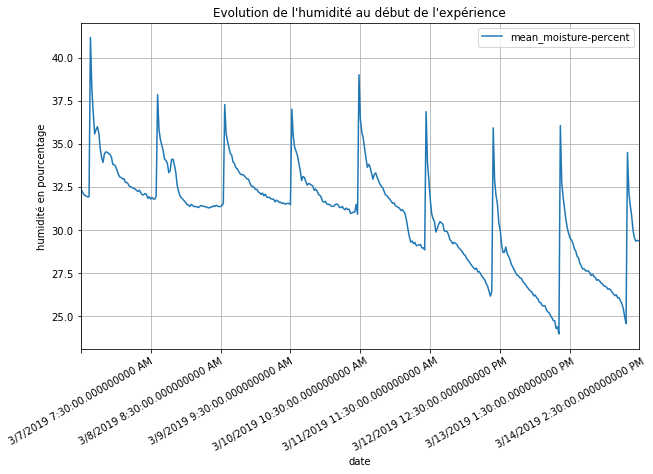

In [39]:
dfGraph = dfdebut.iloc[range(0,400),:]

ax = dfGraph.plot(x='date', y=['mean_moisture-percent'],figsize=(10, 6),rot=30,grid=True, title="Evolution de l'humidité au début de l'expérience")
ax.set_ylabel("humidité en pourcentage")